# Working with data 2017. Class 5
## Contact
Javier Garcia-Bernardo
garcia@uva.nl

## Linear regression

In [113]:
##Some code to run at the beginning of the file, to be able to show images in the notebook
##Don't worry about this cell

#Print the plots in this screen
%matplotlib inline 

#Be able to plot images saved in the hard drive
from IPython.display import Image 

#Make the notebook wider
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:90% !important; }</style>"))

import seaborn as sns
import pylab as plt
import pandas as pd
import numpy as np
import scipy.stats

import statsmodels.formula.api as smf

In [114]:
def qq_plot(x):
    (osm, osr),(slope, intercept, r)  = scipy.stats.probplot(x, dist='norm', plot=None)
    plt.plot(osm, osr, '.', osm, slope*osm + intercept)
    plt.xlabel('Quantiles',fontsize=14)
    plt.ylabel('Quantiles Obs',fontsize=14)  

# 1. Linear Regression
## 1.1 Assumptions

- A) Linearity and additive terms: 
    - Check: Residuals vs fitted values, also the cond number is affected
    - Solution if it doesn't hold: Transform variables (e.g. log(x)) or add interaction terms.
- B) No autocorrealtion in residuals:
    - Check: The Durbin – Watson (DW) statistic should be close to 2
    - Solution: Add/Drop a variable. Sometimes it cannot be solved.
- C) Homoskedasticity (the residuals must have constant variances).
    - Check: Residuals vs fitted values. Use a correlation table.
    - Solution: Add/Drop variables
- D) Normality in the residuals:
    - Check: QQ plot
    - Solution: Transform your variables (np.log(x), np.exp(x), it depends on the shape of your distribution) Related to assumption 1 
- E) No multicollinearity (no high correlation in the independent variables):
    - Check: Condition number should be lower than 30-100
    - Solution: Drop/combine independent varialbes    
- F) No outliers
    - Check: Cook's distance
    - Solution: It depends...

- While normality of independent variables is not an assumption, it make the other assumptions easier

Source: https://www.analyticsvidhya.com/blog/2016/07/deeper-regression-analysis-assumptions-plots-solutions/

### Example: Check if the market capitalization of a company depends on the revenue

In [58]:
df = pd.read_csv("../class5/data/big3_position.csv",sep="\t").dropna()
df.head()

,Company_name,Company_ID,Big3Share,Position,Revenue,Assets,Employees,MarketCap,Exchange,TypeEnt
23,"PROTEOSTASIS THERAPEUTICS, INC.",US000980301,0.00,103,4312.0,18690.0,43.0,304126.0,NASDAQ National Market,Industrial company
24,"TELIGENT, INC.",US010355758,9.75,3,44250.0,184762.0,107.0,307744.0,NASDAQ National Market,Industrial company
26,BAR HARBOR BANKSHARES,US010393663,7.22,1,53863.0,1580055.0,221.0,203279.0,NYSE MKT,Bank
27,IDEXX LABORATORIES INC,US010393723,17.10,1,1601892.0,1474993.0,6800.0,8064073.0,NASDAQ National Market,Industrial company
28,"FIRST BANCORP, INC (THE)",US010404322,9.56,1,53162.0,1559660.0,218.0,216066.0,NASDAQ National Market,Bank


## All problems (caused by the lognormal distribution)
- Check the Cond No

In [59]:
#How to run a regression (be careful, this is wrong)
mod = smf.ols(formula='MarketCap ~ Revenue + Employees', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              MarketCap   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     1672.
Date:                Mon, 30 Jan 2017   Prob (F-statistic):               0.00
Time:                        16:23:21   Log-Likelihood:                -56798.
No. Observations:                3136   AIC:                         1.136e+05
Df Residuals:                    3133   BIC:                         1.136e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.266e+06   3.27e+05      6.933      0.0

In [60]:
#Our independent variables are highly correlated
scipy.stats.pearsonr(df["Revenue"],df["Employees"])

(0.75315303757182506, 0.0)

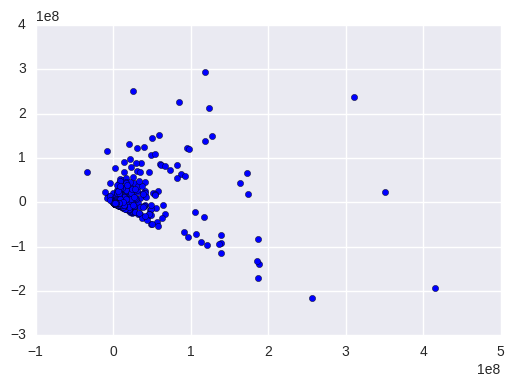

In [61]:
#Residuals vs fitted
plt.scatter(res.predict(), res.resid)

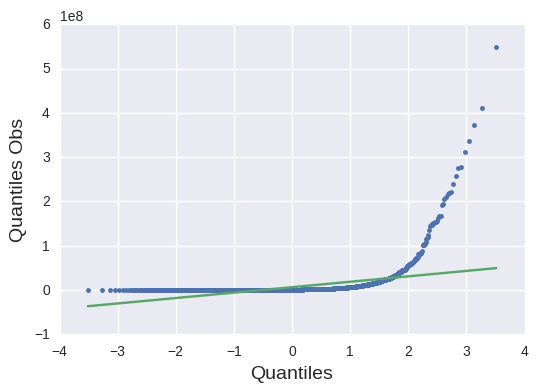

In [62]:
#And it's caused by this -> Very very far from normal, it's not additive
qq_plot(df["MarketCap"])

## Fix: Transform varialbes

In [63]:
df["log_MarketCap"] = np.log10(df["MarketCap"])
df["log_Revenue"] = np.log10(df["Revenue"])
df["log_Employees"] = np.log10(df["Employees"])
df = df.loc[np.isfinite(df["log_MarketCap"])]
df = df.loc[np.isfinite(df["log_Revenue"])]

/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


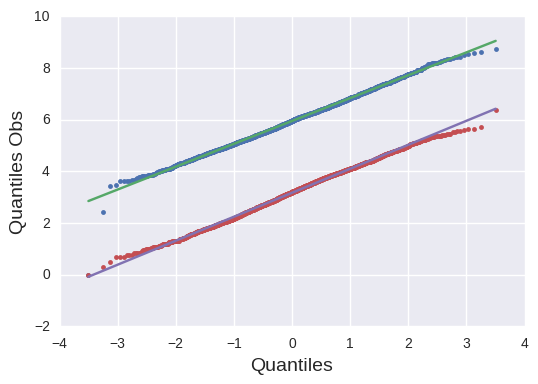

In [64]:
#And it's caused by this -> Very very far from normal, it's not additive
qq_plot(df["log_MarketCap"])
qq_plot(df["log_Employees"])

In [65]:
#This now owrks
mod = smf.ols(formula='log_MarketCap ~ log_Employees', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          log_MarketCap   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     2678.
Date:                Mon, 30 Jan 2017   Prob (F-statistic):               0.00
Time:                        16:23:26   Log-Likelihood:                -2951.8
No. Observations:                3013   AIC:                             5908.
Df Residuals:                    3011   BIC:                             5920.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         3.8737      0.042     92.662

# Fit diagnostiscs 


### A. Linearity and additive 
- No weird shape, regression line around zero -> Good

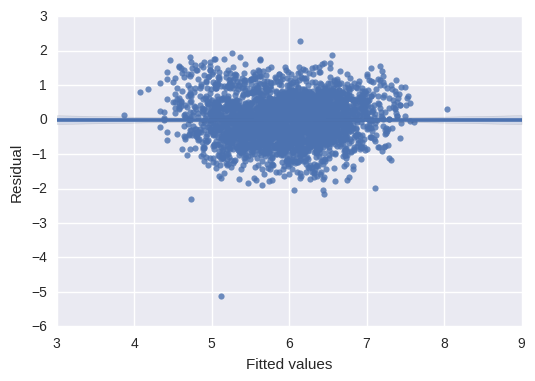

In [12]:
sns.regplot(res.predict(),res.resid)
plt.ylabel('Residual')
plt.xlabel('Fitted values')


### B. Auto-correalation
- Durbin-Watson:                   1.996 --> Good

### C. Homoskedasticity in residuals
- Residuals look good

### D. Normality in residuals
- Residuals look good

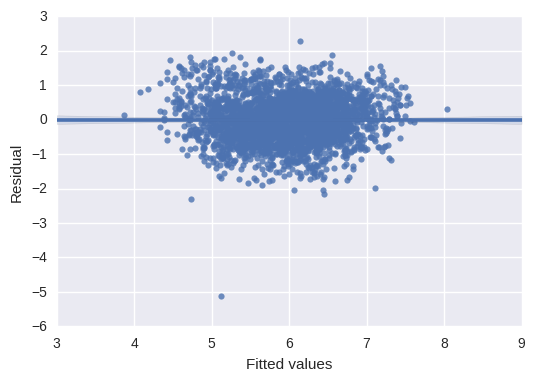

In [13]:
sns.regplot(res.predict(),res.resid)
plt.ylabel('Residual')
plt.xlabel('Fitted values')


(-3, 3)

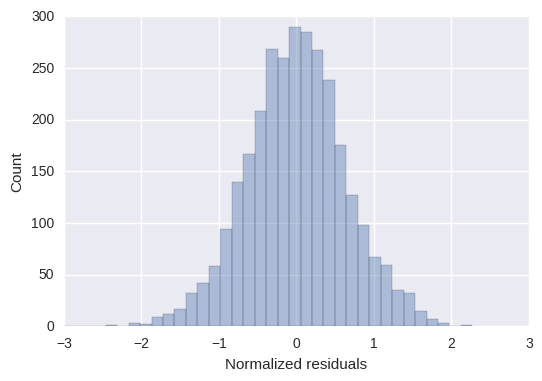

In [14]:
#Normality
sns.distplot(res.resid,kde=False)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')
plt.xlim((-3,3))

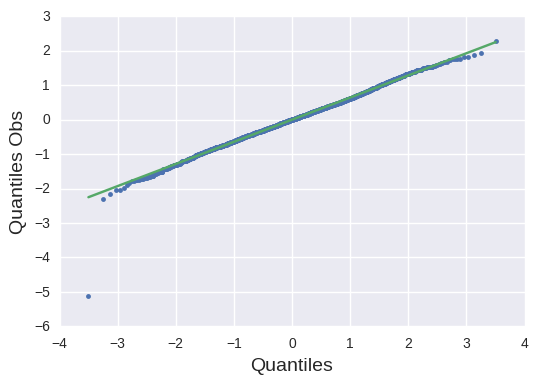

In [15]:
#Normality 2
qq_plot(res.resid)

### E. No multicollinearity among independent variables
- Cond. No.                         11.8 --> Good
- Only one variable so it's okay. Otherwise a correlation plot / scatter matrix help


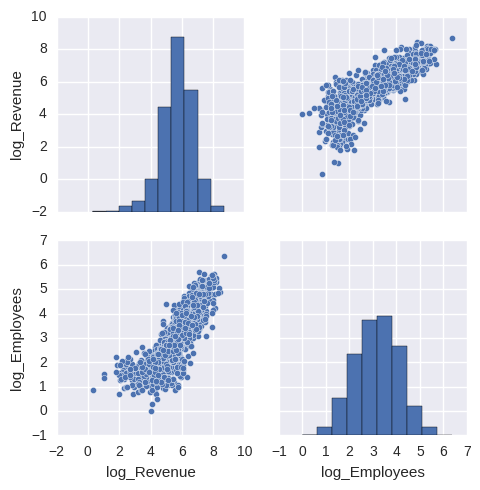

In [16]:
sns.pairplot(df.loc[:,["log_Revenue","log_Employees"]])

## Cooks distance 
- Estimate of the influence of a data point when performing a least-squares regression analysis

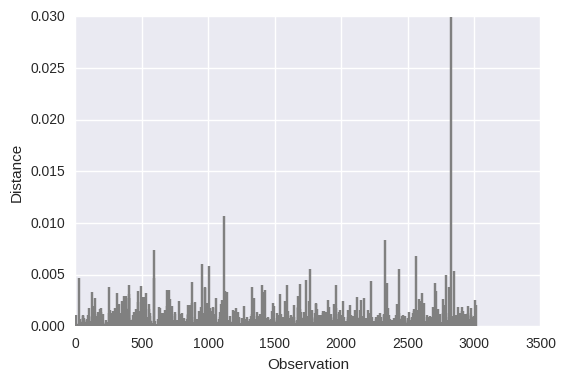

In [17]:
#Larger cook distance, larger influence
influence = res.get_influence()
(c, p) = influence.cooks_distance
plt.vlines(np.arange(len(c)), ymin=0, ymax=c,color="gray")
plt.ylabel("Distance")
plt.xlabel("Observation")

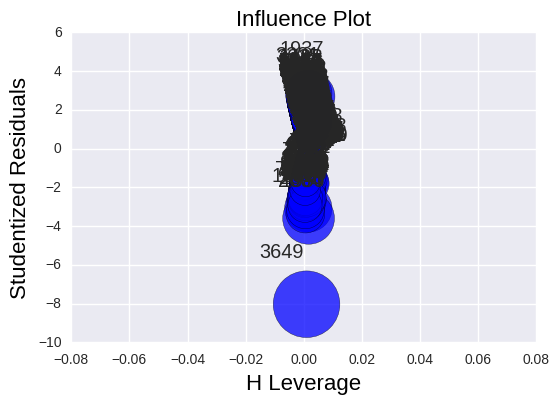

In [18]:
#Larger leverage, larger influence. If high residual and high leverage -> Probably affecting the model
from statsmodels.graphics.regressionplots import *
influence_plot(res)
plt.show()


# Other types of models
- Univariate **Linear** Regression 
        mod = smf.ols(formula='log_MarketCap ~ log_Employees', data=df)
- Multivariate **Linear** Regression 
        mod = smf.ols(formula='log_MarketCap ~ log_Employees + log_Revenue', data=df)
- Multivariate **Linear** Regression with interactions
        mod = smf.ols(formula='log_MarketCap ~ log_Employees * log_Revenue', data=df)
- Multivariate **Linear** Regression with categorical data
        mod = smf.ols(formula='log_MarketCap ~ log_Employees + C(Position)', data=df)
- Multivariate **Logistic** Regression with categorical data --> In this case, the dependent variable MUST be categorical (0 or 1))
        mod = smf.logit(formula='xx ~ log_Employees + C(Position)', data=df)
- Mixed effect (**multilevel**) model with random intercepts --> In this case, there must be some groups (for instance countries)
        mod = smf.mixedlm(formula='log_MarketCap ~ log_Employees', data=df,groups="Position")
- Mixed effect (**multilevel**) model with random intercepts and random slopes
        mod = smf.mixedlm(formula='log_MarketCap ~ log_Employees', data=df,groups="Position", re_formula="Year")

## Example: Multilevel model with random intercepts

In [115]:
df = pd.read_csv("data/test_mixed.csv")
df.head()

,happiness,wealth,country
0,0.030247,0.328295,NL
1,0.059776,0.328493,NL
2,0.178334,0.349546,NL
3,0.227398,0.525887,NL
4,0.256253,0.594296,NL


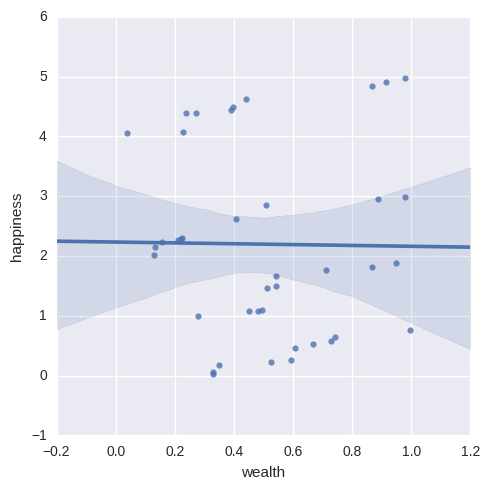

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              happiness   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                  0.005689
Date:                Mon, 30 Jan 2017   Prob (F-statistic):              0.940
Time:                        16:28:42   Log-Likelihood:                -74.590
No. Observations:                  40   AIC:                             153.2
Df Residuals:                      38   BIC:                             156.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.2322      0.541      4.127      0.000         1.137     3.327
wealth        -0.0709      0.940     -0.075      0.940        -1.974     1.832
==============================================================================
Omnibus:                        6.733   Durbin-Watson:                   0.018
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                3.095
Skew:                           0.413   Prob(JB):                        0.213
Kurtosis:                       1.916   Cond. No.                         4.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
sns.lmplot("wealth","happiness",data=df)
plt.show()
mod = smf.ols(formula='happiness ~ wealth', data=df)#,groups="country")
res = mod.fit()
res.summary()

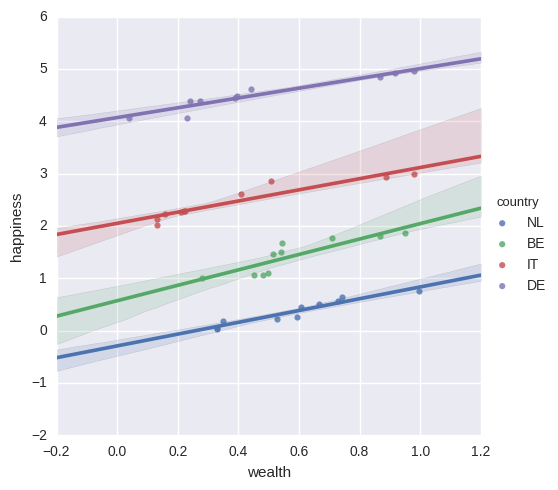

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: happiness
No. Observations: 40      Method:             REML     
No. Groups:       4       Scale:              0.0178   
Min. group size:  10      Likelihood:         8.9898   
Max. group size:  10      Converged:          Yes      
Mean group size:  10.0                                 
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     1.645    0.918  1.793 0.073 -0.153  3.444
wealth        1.084    0.082 13.174 0.000  0.923  1.245
Intercept RE  3.359   26.838                           
=======================================================

"""

In [91]:
sns.lmplot("wealth","happiness",data=df,hue="country")
plt.show()
mod = smf.mixedlm(formula='happiness ~ wealth', data=df,groups="country")
res = mod.fit()
res.summary()